In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [40]:
!pip install tdqm

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=fd4fce45d49a08b9e4dcc02b4cb553d11f90798840e350b3bfcafe8b00200bd5
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm


In [43]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


In [4]:
def compute_similarity(sentences, model_name="bert-base-uncased", max_length=512):
    """
    Compute the cosine similarity between the first sentence and all others using a pre-trained BERT model.
    Args:
        sentences (list of list of str): A list of sentences where the first one is compared to the rest.
        model_name (str): The pre-trained BERT model name (default: 'bert-base-uncased').
        max_length (int): Maximum sequence length for tokenization (default: 128).
    Returns:
        numpy.ndarray: Cosine similarity values between the first sentence and the rest.
    """

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Tokenization and input preparation
    tokens = {"input_ids": [], "attention_mask": []}

    for sentence in sentences:
        new_tokens = tokenizer.encode_plus(
            "\n".join(sentence),
            max_length=max_length,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )

        tokens["input_ids"].append(new_tokens["input_ids"][0])
        tokens["attention_mask"].append(new_tokens["attention_mask"][0])

    tokens["input_ids"] = torch.stack(tokens["input_ids"])
    tokens["attention_mask"] = torch.stack(tokens["attention_mask"])

    # Generate embeddings
    outputs = model(
        **tokens
    )  # Passing the input tensors through the BERT model to generate embeddings.
    embeddings = (
        outputs.last_hidden_state
    )  # A tensor that contains the embeddings of all tokens for all sentences.
    attention = tokens[
        "attention_mask"
    ]  # Used later to ignore padding tokens during the computation.

    # Mask embeddings
    mask = (
        attention.unsqueeze(-1).expand(embeddings.shape).float()
    )  # extra dimension to the attention mask to match the shape of embeddings.
    # repeats the mask across the embedding dimensions.
    masked_embeddings = embeddings * mask  # nullify padding embeddings

    # Compute mean pooling
    summed = torch.sum(
        masked_embeddings, dim=1
    )  # sum of token embeddings for each sentence along the token dimension (dim=1).
    counts = torch.clamp(
        mask.sum(dim=1), min=1e-9
    )  # counts the number of valid (non-padding) tokens & prevent division by zero
    mean_pooled = summed / counts
    mean_pooled = (
        mean_pooled.detach().numpy()
    )  # divides the sum by # of valid tokens to compute the average embedding for each sentence

    # cosine similarity
    similarity = cosine_similarity(
        [mean_pooled[0]], mean_pooled[1:]
    )  # calculating the similarity
    return similarity

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix obtained from your metrics
cm = np.array([[0, 706], [0, 673]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


def compute_metrics(true_labels, predicted_labels):
    """
    Compute evaluation metrics including accuracy, precision, recall, F1 score, and confusion matrix.
    
    Args:
        true_labels (list): List of true labels.
        predicted_labels (list): List of predicted labels.
        
    Returns:
        dict: Dictionary containing the metrics and confusion matrix.
    """
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Compute other metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    
    # Return the metrics along with the confusion matrix
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm
    }

## BertSequenceClassifier

In [6]:
!pip install gdown

In [60]:
file_id = "1F6xWrYqsGD-o8eSwIbUedLmtSoNNfhVv"

In [61]:
import gdown
destination = "finalized_model.pth"

gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

import os

file_size = os.path.getsize(destination)
print(f"Downloaded file size: {file_size / (1024 * 1024):.2f} MB")

Downloading...
From (original): https://drive.google.com/uc?id=1F6xWrYqsGD-o8eSwIbUedLmtSoNNfhVv
From (redirected): https://drive.google.com/uc?id=1F6xWrYqsGD-o8eSwIbUedLmtSoNNfhVv&confirm=t&uuid=214a993d-14cb-4f1c-8ff3-ca90694b733b
To: /kaggle/working/finalized_model.pth
100%|██████████| 438M/438M [00:06<00:00, 63.7MB/s] 


Downloaded file size: 417.73 MB


In [62]:
import torch

from transformers import BertTokenizer, BertForSequenceClassification

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Load the saved state_dict and map it to the appropriate device
model.load_state_dict(torch.load("finalized_model.pth", map_location=device))

# Move the model to the selected device
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_24/2426585078.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We rec

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [20]:
import pandas as pd

syntetic_data = pd.read_csv('/kaggle/input/synteticdata/pride_and_prejudice_all_chapters.csv')

In [14]:
import torch.nn.functional as F
import torch

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)


def predict(sentence1, sentence2, model, tokenizer, device, max_length=128):
    # Tokenize the input
    inputs = tokenizer(
        sentence1,
        sentence2,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    ).to(
        device
    )  # Move inputs to the same device as the model

    # Run the model
    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
        )

        logits = outputs.logits

    # Apply softmax to get probabilities
    probs = F.softmax(logits, dim=1)
    predicted_class = torch.argmax(probs).item()

    return predicted_class, probs

In [16]:
labels = ["not similar", "similar"]

Sentence 1: The cat is sleeping on the sofa.
Sentence 2: A cat is curled up and napping on the couch.
Predicted Class: 0


In [31]:
syntetic_data['is_duplicate'].value_counts()

syntetic_data.dropna(inplace = True)

#syntetic_data[syntetic_data['is_duplicate'].isna()]


In [35]:
syntetic_data['is_duplicate'] = syntetic_data['is_duplicate'].astype(int)

,original,paraphrased,is_duplicate
0,"Not all that Mrs. Bennet, however, with the as...","Not all that Mrs. Bennet, even with the help o...",1
1,They attacked him in various ways; with barefa...,They approached him in numerous ways; with dir...,1
2,Her report was highly favourable.,Her account was exceedingly positive.,1
3,Sir William had been delighted with him.,Sir William had been utterly charmed by him.,1
4,"He was quite young, wonderfully handsome, extr...","He was quite young, strikingly attractive, imm...",1
...,...,...,...
114,"You and the girls may go, or you may send them...","""I don’t see any reason for that.""",0
115,"""My dear, you flatter me.","""You and the girls can go, or perhaps it’s bet...",0
116,"I certainly _have_ had my share of beauty, but...","""My dear, you are too kind.""",0
117,"When a woman has five grown up daughters, she ...","""I’ve definitely enjoyed my share of beauty, b...",0


In [38]:
sentences = syntetic_data[['original', 'paraphrased']].values.tolist()  # Extract pairs of sentences
true_labels = syntetic_data['is_duplicate'].values.tolist()  # Extract true labels


## BERT Classifier

In [83]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

predicted_class, probabilities = predict(sentence1, sentence2, model, tokenizer, device)

print(f"Predicted Class: {predicted_class}")


Predicted Class: 1


In [84]:
res = []
for sentence in tqdm(sentences):
    predicted_class, probabilities = predict(sentence[0], sentence[1], model, tokenizer, device)

    res.append(predicted_class)



100%|██████████| 119/119 [00:30<00:00,  3.89it/s]


In [85]:
syntetic_data['BertClassifierPrediction'] = res

In [86]:
syntetic_data['BertClassifierPrediction'].value_counts()

BertClassifierPrediction
0    73
1    46
Name: count, dtype: int64

In [87]:
syntetic_data.shape

(119, 4)

In [93]:
dissimalar_df = syntetic_data[syntetic_data['BertClassifierPrediction'] != syntetic_data['is_duplicate']].reset_index()

In [107]:
dissimalar_df.to_csv('dissimilar.csv')

In [101]:
dissimalar_df[dissimalar_df['index'] == 52][[ 'original', 'paraphrased','is_duplicate' ]].values[0]

array(['Jane was as much gratified by this, as her mother could be, though in a quieter way.',
       'Jane was as pleased by this as her mother, albeit in a quieter manner.',
       1], dtype=object)

In [104]:
dissimalar_df[dissimalar_df['index'] == 15][[ 'original', 'paraphrased','is_duplicate' ]].values[0]

array(['A single man of large fortune; four or five thousand a year.',
       'Of course, my dear, he is single!', 0], dtype=object)

In [52]:
syntetic_data[syntetic_data['is_duplicate'] == 1]

,original,paraphrased,is_duplicate,BertClassifierPrediction
0,"Not all that Mrs. Bennet, however, with the as...","Not all that Mrs. Bennet, even with the help o...",1,0
1,They attacked him in various ways; with barefa...,They approached him in numerous ways; with dir...,1,0
2,Her report was highly favourable.,Her account was exceedingly positive.,1,0
3,Sir William had been delighted with him.,Sir William had been utterly charmed by him.,1,0
4,"He was quite young, wonderfully handsome, extr...","He was quite young, strikingly attractive, imm...",1,0
5,Nothing could be more delightful!,Nothing could be more exciting!,1,0
6,To be fond of dancing was a certain step towar...,To enjoy dancing was considered a definite ste...,1,0
19,"His brother-in-law, Mr. Hurst, merely looked t...","His brother-in-law, Mr. Hurst, merely appeared...",1,0
20,The gentlemen pronounced him to be a fine figu...,The men considered him an excellent figure of ...,1,0
21,Mr. Bingley had soon made himself acquainted w...,Mr. Bingley had quickly acquainted himself wit...,1,0


## Cosine Similarity

In [112]:

# Compute similarity
similarity_scores = []
for sentence_pair in tqdm(sentences):
    similarity_scores.append(compute_similarity(sentence_pair)[0][0])

# Make predictions based on similarity threshold (e.g., 0.6)
predicted_labels = [1 if score > 0.7 else 0 for score in similarity_scores]



100%|██████████| 119/119 [05:04<00:00,  2.56s/it]


In [114]:
syntetic_data['CosineSimilarityResult'] = predicted_labels

In [116]:
syntetic_data.to_csv('Results.csv')

In [105]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Generate two similar sentences for testing
sentence1 = "A single man of large fortune; four or five thousand a year."
sentence2 = "Of course, my dear, he is single!"

# Perform inference
predicted_class, probabilities = predict(sentence1, sentence2, model, tokenizer, device)

# Print results
print(f"Sentence 1: {sentence1}")
print(f"Sentence 2: {sentence2}")
print(f"Class Id: {predicted_class}")

print(f"Predicted Class: {labels[predicted_class]}")
print(f"Class Probabilities: {probabilities}")

Sentence 1: A single man of large fortune; four or five thousand a year.
Sentence 2: Of course, my dear, he is single!
Class Id: 1
Predicted Class: similar
Class Probabilities: tensor([[0.4585, 0.5415]])


In [121]:
syntetic_data.head()

,original,paraphrased,is_duplicate,BertClassifierPrediction,CosineSimilarityResult
0,"Not all that Mrs. Bennet, however, with the as...","Not all that Mrs. Bennet, even with the help o...",1,1,1
1,They attacked him in various ways; with barefa...,They approached him in numerous ways; with dir...,1,1,1
2,Her report was highly favourable.,Her account was exceedingly positive.,1,0,1
3,Sir William had been delighted with him.,Sir William had been utterly charmed by him.,1,1,1
4,"He was quite young, wonderfully handsome, extr...","He was quite young, strikingly attractive, imm...",1,1,1


## Metrics

In [120]:
predicted_labels = syntetic_data['BertClassifierPrediction'].to_list()
true_labels = syntetic_data['is_duplicate'].to_list()
compute_metrics( true_labels , predicted_labels )

{'accuracy': 0.8907563025210085,
 'precision': 0.9565217391304348,
 'recall': 0.8,
 'f1_score': 0.8712871287128713,
 'confusion_matrix': array([[62,  2],
        [11, 44]])}

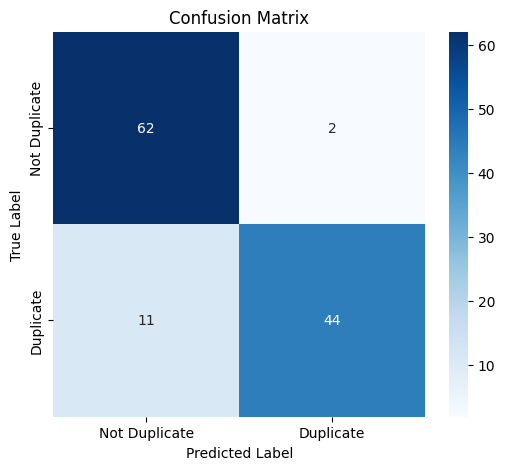

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix obtained from your metrics
cm = np.array([[62,  2],[11, 44]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('BertClassifierSynthetic.png')
plt.show()

In [122]:
predicted_labels = syntetic_data['CosineSimilarityResult'].to_list()
true_labels = syntetic_data['is_duplicate'].to_list()
compute_metrics( true_labels , predicted_labels )

{'accuracy': 0.5042016806722689,
 'precision': 0.4824561403508772,
 'recall': 1.0,
 'f1_score': 0.650887573964497,
 'confusion_matrix': array([[ 5, 59],
        [ 0, 55]])}

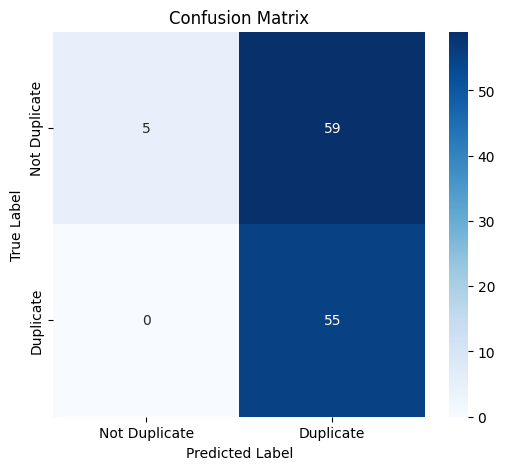

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix obtained from your metrics
cm = np.array([[ 5, 59], [ 0, 55]])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Duplicate", "Duplicate"], yticklabels=["Not Duplicate", "Duplicate"])

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig('CosineSimilaritySynthetic.png')
plt.show()

In [134]:
syntetic_data['label'] = syntetic_data['is_duplicate'].apply(lambda x : 'Similar' if x==1 else 'Not Similar' )

In [135]:
syntetic_data['label']

0          Similar
1          Similar
2          Similar
3          Similar
4          Similar
          ...     
114    Not Similar
115    Not Similar
116    Not Similar
117    Not Similar
118    Not Similar
Name: label, Length: 119, dtype: object

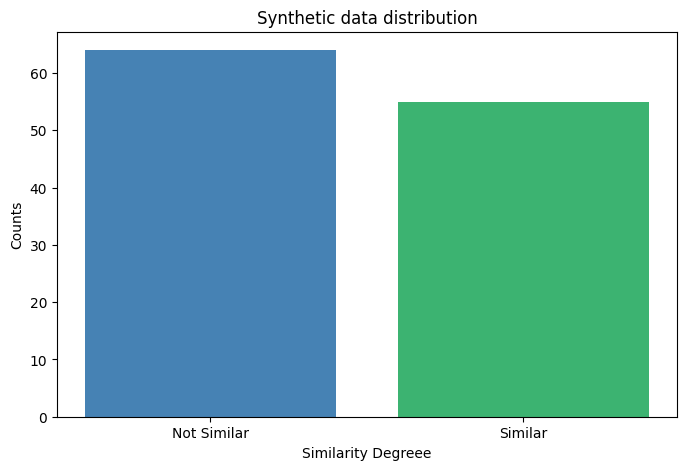

In [140]:
category_counts = syntetic_data['label'].value_counts()

# Plot the bar graph
plt.figure(figsize=(8, 5))
plt.bar(category_counts.index, category_counts.values, color=['steelblue', 'mediumseagreen'])

# Add labels and title
plt.title("Synthetic data distribution")
plt.xlabel("Similarity Degreee")
plt.ylabel("Counts")
plt.savefig('SyntheticDataEDA.png')
# Show the plot
plt.show()